Problem 17 from the advent of code calendar 2022.

December 31, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.set_printoptions(linewidth=250)


In [2]:
#Global variables

WELL_WIDTH = 7
ROCK_HEIGHT = 4
ROCK_ADD_HEIGHT = 3
MAX_ROCKS = 2022

ROCK1 = np.array([[0,0,1,1,1,1,0],
                  [0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0]])

ROCK2 = np.array([[0,0,0,1,0,0,0],
                  [0,0,1,1,1,0,0],
                  [0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0]])

ROCK3 = np.array([[0,0,1,1,1,0,0],
                  [0,0,0,0,1,0,0],
                  [0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0]])

ROCK4 = np.array([[0,0,1,0,0,0,0],
                  [0,0,1,0,0,0,0],
                  [0,0,1,0,0,0,0],
                  [0,0,1,0,0,0,0]])

ROCK5 = np.array([[0,0,1,1,0,0,0],
                  [0,0,1,1,0,0,0],
                  [0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0]])



BASIC_ROCKS = [ROCK1,ROCK2,ROCK3,ROCK4,ROCK5] 
    


**IMPORTANT!**

We are going to let the first array index represent HEIGHT.  The second array index will be associated with the column, aka where in the width something might be.

In [3]:


def plot_helper(grid, reverse = True):
    """
    Basically making imshow behave.  sigh.  The best method was to replace imshow with Seaborn.
    
    This function is for looking at what is going on.  Basically a visual helper for chasing down 
    indexing errors.
    """
    
    ax = sns.heatmap(grid, square=True, linewidths=.05, cbar = False,cmap="crest" )
    if reverse:
        ax.invert_yaxis()
    plt.show()

    
    
    
class Jets():
    
    jets = ''
    pos = 0
    
    def __init__(self,jet_str):
        
        self.jets = jet_str
        self.pos = 0
        assert len(self.jets) > 0

    def __repr__(self):
        return self.jets
        
    def get_next_jet(self):
        
        rval = self.jets[self.pos]
        self.pos = (self.pos + 1)%len(self.jets)
        return rval
    
    def look_ahead(self):
        return self.jets[self.pos]
    


    

    
class Rock():
    
    width = WELL_WIDTH
    height = ROCK_HEIGHT
    cur_position = None
    rock_num = None
    
    def __init__(self,rock_num):
        
        self.rock_num = (rock_num - 1)%len(BASIC_ROCKS) + 1
        self.rock = BASIC_ROCKS[self.rock_num -1]
        assert self.rock.shape == (self.height,self.width)
        
    def __repr__(self):
        return '{}'.format(self.rock)
    
    def plot(self, reverse = True):
        plot_helper(self.rock,reverse=reverse)
    
    def set_position(self,position):
        self.cur_position = position
        
    def overlap(self,grid):
        assert(self.rock.shape == grid.shape)
        if (self.rock + grid).max() > 1:
            return True
        else:
            return False
    
    def next_grid(self,jet):
        """ Note the jet here is a simply string.  This does not call a jet class.
        """
        ng = self.rock
        if jet == '>':
            #Check that the last column is all zeros so have room to move over
            if self.rock[:,-1].max() == 0:
                ng = np.roll(self.rock,1,axis = 1)
        elif jet == '<':
            if self.rock[:,0].max() == 0:
                ng = np.roll(self.rock,-1,axis = 1)
        else:
            print("WARNING! Invalid jet {}".format(jet))
        return ng
        
    def apply_jet(self,jet):
        self.rock = self.next_grid(jet)
        
        
        
        
    
        
class Chamber():
    
    width = WELL_WIDTH
    height = MAX_ROCKS*ROCK_HEIGHT
    reset_height = 6000
    reset_trigger = reset_height + 1000  #estimating that 1000 rows is enough to stop any future block
    logging = False
    log = []
    
    def __init__(self, logging = False):
        
        self.grid = np.zeros((self.height,self.width))
        self.bottom_index = 0    #This is the lowest index where there are no rock fragments
        self.reset_count = 0   #This is the number of times that we've gone 
        self.logging = logging
        self.log = []
    
    def __repr__(self):
        top = min(self.height,self.bottom_index + ROCK_HEIGHT)
        return '{}'.format(self.grid[:top,:])
    
    def plot(self, reverse = True):
        top = min(self.height,self.bottom_index + ROCK_HEIGHT)
        plot_helper(self.grid[:top,:],reverse = reverse)

    def flush_grid(self):
        if self.bottom_index > self.reset_trigger:
            self.reset_count = self.reset_count + 1
            new_grid = self.grid[self.reset_height:]
            new_grid = np.append(new_grid, np.zeros((self.height - new_grid.shape[0],self.width)), axis=0)
            #print("Old grid shape {}  New grid shape {}".format(self.grid.shape,new_grid.shape))
            self.grid = new_grid
            self.bottom_index = self.bottom_index - self.reset_height
            
    def get_rock_height(self):
        return self.bottom_index + self.reset_count*self.reset_height
    
    
    def add_rock(self,rock,jets, plots = False):
        
        def plot_process():
            ctop = min(self.height,self.bottom_index + ROCK_HEIGHT+ROCK_ADD_HEIGHT)
            composite = self.grid[:ctop,:].copy()
            composite[rock.cur_position:rock.cur_position+rock.height] += 2*rock.rock
            plot_helper(composite)
                   
        rock.set_position(self.bottom_index + ROCK_ADD_HEIGHT)  #Set position on incoming rock
        start_pos = rock.cur_position
        if plots:
            print("Initial appearance")
            plot_process()
        
        
        keep_going = True
        while keep_going:
            nj = jets.get_next_jet()
            pg = rock.next_grid(nj).copy()  #Get the grid that would result from a jet shift
            pg = pg + self.grid[rock.cur_position:rock.cur_position + rock.height,:]  #Add it to grid at the current rock position
            
            if pg.max()< 2:  #If there are no overlaps, apply the jet
                rock.apply_jet(nj) #Apply the jet
                ja = 'Jet applied'
            else:
                ja = 'Jet unable to move rock'
            
            #Next up see if the rock can fall.  If it can, let it fall.           
            if rock.cur_position == 0:
                keep_going = False
                ma = "Bottomed out, no more jets"
                if self.reset_count > 0:
                    print("WARNING!!!! Bottomed out in after a flush has occured.  Increase reset trigger delta.  COMPUTATION IS WRONG!!!")
            elif rock.overlap(self.grid[rock.cur_position-1:rock.cur_position-1 + rock.height,:]): #Overlap is true
                keep_going = False
                ma = 'Hit a rock, no more moving down'
            else:
                rock.cur_position = rock.cur_position - 1
                ma = 'Rock now at current position {}'.format(rock.cur_position)
                
            if plots:
                print('{}  and {}'.format(ja,ma))
                plot_process()
        
        
        #Figure out where the rock ended up and log it if logging is enabled
        if self.logging:
            fall = start_pos - rock.cur_position 
            ypos = np.where(rock.rock.sum(axis = 0)>0)[0][0]
            self.log.append([self.get_rock_height(),rock.cur_position,rock.rock_num,ypos,fall])
            
            
        #Add the final rock grid to the grid
        self.grid[rock.cur_position:rock.cur_position + rock.height,:] += rock.rock
        #Update the new bottom index
        while self.grid[self.bottom_index].sum() > 0:
            self.bottom_index = self.bottom_index + 1
        #Flush grid if needed
        self.flush_grid()
        if plots:   
            print("New bottom index is {}".format(self.bottom_index))
        
        assert self.grid.max() < 2
        if plots:
            self.plot()
        
        return None
        
            
    

Initial appearance


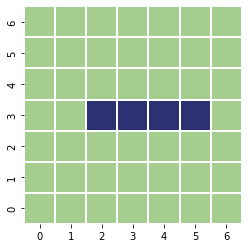

Jet applied  and Rock now at current position 2


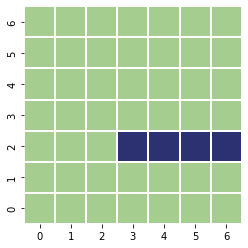

Jet applied  and Rock now at current position 1


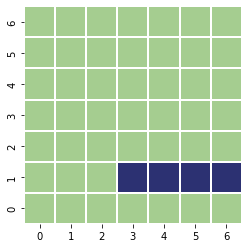

Jet applied  and Rock now at current position 0


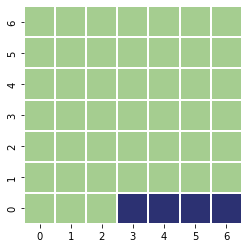

Jet applied  and Bottomed out, no more jets


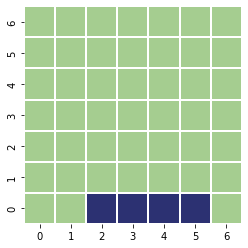

New bottom index is 1


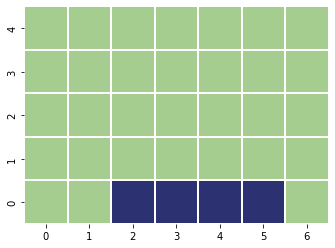

Initial appearance


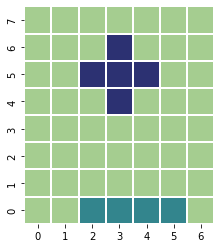

Jet applied  and Rock now at current position 3


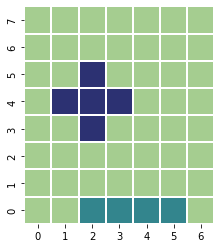

Jet applied  and Rock now at current position 2


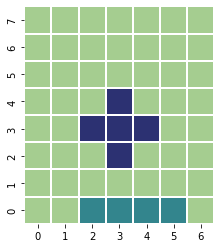

Jet applied  and Rock now at current position 1


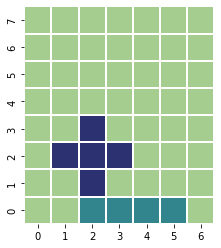

Jet applied  and Hit a rock, no more moving down


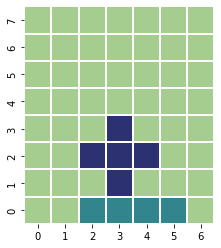

New bottom index is 4


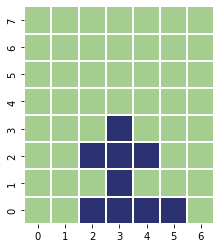

Initial appearance


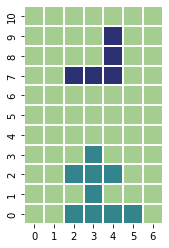

Jet applied  and Rock now at current position 6


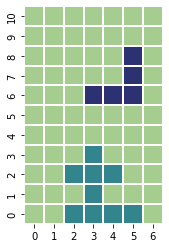

Jet applied  and Rock now at current position 5


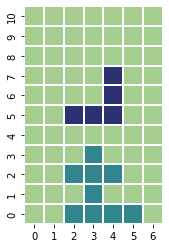

Jet applied  and Rock now at current position 4


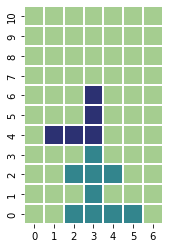

Jet applied  and Rock now at current position 3


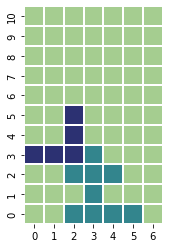

Jet unable to move rock  and Hit a rock, no more moving down


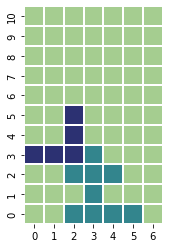

New bottom index is 6


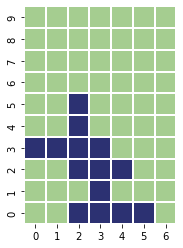

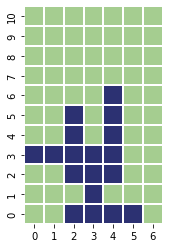

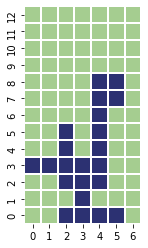

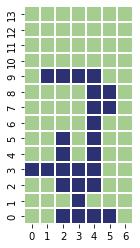

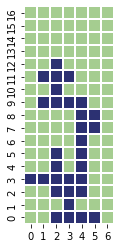

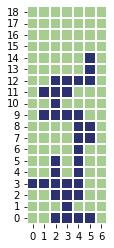

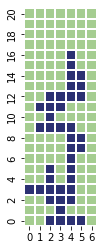

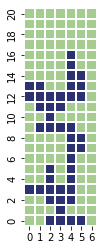

In [4]:
r = Chamber(logging = True)
sample_jets = Jets('>>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>')

for i in range(1,4):
    r.add_rock(Rock(i),sample_jets,plots = True)

for i in range(4,11):
    r.add_rock(Rock(i),sample_jets,plots = False)
    r.plot()

In [5]:
r.log

[[0, 0, 1, 2, 3],
 [1, 1, 2, 2, 3],
 [4, 3, 3, 0, 4],
 [6, 3, 4, 4, 6],
 [7, 7, 5, 4, 3],
 [9, 9, 1, 1, 3],
 [10, 10, 2, 1, 3],
 [13, 12, 3, 3, 4],
 [15, 13, 4, 4, 5],
 [17, 12, 5, 0, 8]]

In [6]:
example = Chamber(logging=True)
example_jets = Jets('>>><<><>><<<>><>>><<<>>><<<><<<>><>><<>>')

for i in range(1,2023):
    example.add_rock(Rock(i),example_jets,plots = False)

In [7]:
example.bottom_index + example.reset_count*example.reset_height

3068

In [8]:
l = np.array(example.log)
ldf = pd.DataFrame(l,columns = ['bottom_index','rock_position','rock_number','yloc','fall'])
ldf['num_jets'] = ldf.fall + 1
ldf['ending_jet_num'] = ldf.num_jets.cumsum()%len(example_jets.jets)

In [9]:
ldf[ldf.ending_jet_num == 4].head(10)

,bottom_index,rock_position,rock_number,yloc,fall,num_jets,ending_jet_num
0,0,0,1,2,3,4,4


So it looks like the description example may be repeating every 105 blocks.  To confirm this should look at the following

In [10]:
offset = 30
for i in range(10,1000):
    gdiff = np.abs(example.grid[offset:offset+i] - example.grid[offset+i:offset+2*i])
    if gdiff.max() < 1:
        print(i,gdiff.max(),i/53)

53 0.0 1.0
106 0.0 2.0
159 0.0 3.0
212 0.0 4.0
265 0.0 5.0
318 0.0 6.0
371 0.0 7.0
424 0.0 8.0
477 0.0 9.0
530 0.0 10.0
583 0.0 11.0
636 0.0 12.0
689 0.0 13.0
742 0.0 14.0
795 0.0 15.0
848 0.0 16.0
901 0.0 17.0
954 0.0 18.0


So it looks like there is a repeat every 53 rows of the grid.  The question then is what does that represent in terms of rocks.

In [11]:
ldf.iloc[20:70]

,bottom_index,rock_position,rock_number,yloc,fall,num_jets,ending_jet_num
20,36,36,1,1,3,4,32
21,37,36,2,4,4,5,37
22,39,39,3,4,3,4,1
23,42,37,4,2,8,9,10
24,42,41,5,1,4,5,15
25,43,43,1,2,3,4,19
26,44,44,2,2,3,4,23
27,47,46,3,0,4,5,28
28,49,47,4,0,5,6,34
29,51,44,5,5,10,11,5


So I think it is repeating every 35 rocks once we have seen 29 rocks.  

## Running part one.

This time for the data am just using cut and paste because it is easier than "loading" in a file.

In [12]:

with open("17.txt") as f:
    contents = f.readlines()

jets = Jets('>><>><<<<><<<<><<<>><>>><>>>><>>>><>><<>>><<<>>><<>><>>><<>>>><<<<>>><<<>>>><<>>>><<<<>>><<<>><<<<><>><<>><<>><<>>><<<>><<<>>>><<>>>><<<<>>><<<>><>><<<>><<<<>>>><>>>><<>>><<>>><<>>><<><>>>><<<<><<<<>>><>>><<<<>>>><>>>><><<>><<>><<<<><<<<>>><<<<>>><<>>><<<><<<>><<<>><><<>>>><<<<><<<>><<<<>>><>>><<>><<>>><>>>><<<<>>>><<<<>>><<<<>>>><<<<>>>><>><<<<><<<<>><<>>><<>>>><<<>>>><<>>><<<<><<<><>><>><<<<>>><<<>><<<>><<<<>><<>>><<>><<>>><<<<>>>><>><<<<>>>><<<<>>><>>><<<<>>><<>>>><<>>><<><>>><>><<<<><<<<><<<>>><<<<>>><<<<>>>><>>>><<<>>>><>>>><<<<>><>><<<<><>><<<>>><<<<>><<<<>>>><<<>>><<<<>>>><<<><<><<<><<><<<<>><<>>>><<>>>><<<<>><>>><<<<>>>><<<><<<<>>>><<<<>>><<>>>><<>>>><<<><<>><<<>>><<<<>>><><>>>><>><<<<>>>><<<<>>>><>><<><<>>><>><>><<<>>>><<<>>>><<>>><<<<>>><<>><>>>><<<<>>><<<<>><>><><>><>><><<>><<>>>><<<>>>><<<>>><<<><<<><<<<><<<>><>><<>>><<<>><<><<<<>><<<<>><<<>>>><<>><<<><><<><<>>><<<<>>>><<><>><<<<><<>>>><<<><<>><<>>><<<>><<>><<>><<<<>>><<<>><<>><<<>><<<>>><<<>>><<<><<<<>><>>><<>><<<>>>><<>><<>><>><<<<><<>>><>><<>>>><<<>>>><<<><<>>><<<<><<<<>><><<<>>><<>>>><<<>><<<<>><>><<<><<<>>>><<<<>>><>>>><<>>>><<<><<<>><<<<>>><<<>>>><<<>><<<><<><<<>>>><>><<<>><<>><<<<>>>><<<<>>><<<>>><<>>><<<>>>><<>><<<<>>><<<>>><<>><><<>>><<<>>>><<<<>>>><<<<>>>><<<>>><<<<>>>><>><<>>>><>>>><<>>>><<>>>><<<><<<>><<<>>><<>>>><<<>><<>>><<>>><<<<>>><><><<><>>>><<<>>><><<<<>><<<>><<<<>>>><<<<>>><<>><<<>>><>>><<<<>>>><>><<<><<<<>>>><<>>><>>><<>><<>>>><<<<><<><>>>><<<<>><>>>><>>>><><<<>>>><<>><<>>><<>><<>><>>>><<>><<>><<<<>>><<<<>>>><<<<>>><<><<<>>>><<><<><<<<>><<<><<><<<<>>>><>>><>>><<<<>>>><<<>>>><>><<>>>><<>>>><<<>>>><<<><<<><<<<>>>><<>><<><<<>>>><><<><<<>>><>>>><>><>>>><<<<>><<<<>><<<<>>>><><<<<><<><<<>><><<<>>>><><><>>><<<<>>><<<>>>><>><<<>>><<<>><>><<>><<<<>>>><<<>>><<<>>><<<<>>>><>>><<>><<<<>>>><<<>>><>>>><<<><<><<>><<<>><>>>><<<<><<<><<<<>><<<><<<<>>><<<<>>>><<<>>><>><<<>>>><<<<>>><>><<<>>><<<<>>><<<<><<<<>>><<>>>><<>>>><>>><<<>><<<<>>><<<<><<>><>>><<>>>><<<<><>>>><<<>>><><<<>>>><><>>>><>><<<>>><<<>>>><<<<>>><<<<>>><<<<>><<<><<<<><<<>>><>>><<<>><<<<>><<<>><<<><<<<><<><<<<>>><<>><<>>><><<><>>>><<>>><<<<><<>>><>>>><<<>>><<>>>><><<<>>><<><<<<>><><<><<<>>><<<>>>><<>>>><<>>>><<>>><<<<>>><<<>>><<<><<<>>><>><<<>><<>>>><<>>>><<<>>><<<<>><<<<>>>><<<<>>><<>>><<<<><>>>><>>><<>><<<<>>>><<<<><<>>>><<<>>><<<>><<>>><>><<<>>><<<<><<<<>>><>><<<>><<<<>>><<<><<<><<<>>><>><<>>>><>>><<<<>>><<<>>><>>>><<><><<<<><>>>><><>>>><<<<>><<<<>><>>><<>><<<><<>>>><<<>><<<>><<<>>><<<<>><<<>>>><>><<>>><<<<>>>><<>>>><<<>>><<<<>>>><<<>><><<<<>>>><>>>><<>>><<<<>>><<<>>>><<><<<>>><<>>>><<<<>><<<><<>>><<<>>><<<<><<>>>><><<<<>><<<>>>><<<<>><<<<>>><<<>><<<><>><<<>><<<<>>><<>><<>>><<><<<<>><>>>><<<>>>><<>>>><<>>><<>><<<<>><<<>>>><<>>><<<>>><<<<>><>>>><>>>><<<<>>>><<>><<>>><<<<>>>><>><>>><>><<>><<<<>>><<<>>>><<<<>><<<<><<>><<<<>><<<<>><<<<>>><<<>>>><<<>>><<<>><<<<>>>><<<<>>>><<<<><>><>>>><><<<><>><<<<><<<<>><<<>>>><<>>><<<<>>>><<<<><>>><<>>>><<<>>><<<>>>><<><<<<>><<<>>><>>><<><<<<>>><<<<>><<<<><<>>>><>>><<<>>><<<<><<>><<<><>>>><<>>><<<>>><<<><<>>>><<<>><<<><>><<>><<>><<<>>><<<>>>><<>>>><<<<><<>>>><<<<>><>><<>><<<<>><<>>><<>><<<><<<>>><<>>><<<<>>><<<<>><<<<>><<<<>>>><<<>><<<<>><><<>>>><<<<>>><<<>>><<>><<>>>><<<>>><<>><<<<>><<<>>>><<<<>>>><<><<<<>>><><<>>><<<<>>>><<<>>>><<>><><><<<<><<<><<<>>>><>>>><<<<>><<>>>><<<>>>><<>>><><<>>>><<<<>>><<<>>><<>>>><<<>>><<<>><<<>>>><>>><<<<>>>><<<<>>><<>><<><<<>><<>>>><<<>>><><>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>>><<>><><<>>>><<><<>><<<><<<>>>><<<<><<><<<<>><<<>><<<<><<>>>><<><<<>>>><<<>><>><<><<>>><>><<<<>>><<<>>><<>>><<<>><<>>>><<<>>>><<<<>><><<<>>><><<<<>>>><<<<><>>><>>><<<<>><<<>>>><<>>><<<<>>><<<>><<<><<>><<<>>>><<>>><<<>><>>><<<<>>><<>>>><<<<>>><<>>>><<<><<<<><><<<>><<><<>>><><<<>><<<><><<<><<>>>><<<<><>>><<<>>>><<<<>>><<>>><<><<<<>><<<>>><<<<>><><<>>>><>>>><>>>><<<<>>>><<<>><<<>><<<<>>><<<<><>>><<<<><>>>><><<<>><<<<><<>>>><<<<>>>><<>><<>>><><>>>><>><>>><<>>>><<<>>><<<<><<<>><<<<>>><<>>>><<<<>>><<<<>>>><<>>>><>><<><>>>><<<<>>><<<<><>>>><<<<>><<>>><<<<>><<<>><>>><<><<><<<<>><<><<<<>>>><>>>><<>>><>>><<<<>>>><<<>>><<<<><<<<>>><<>>><<>>>><<<><<<>>>><<<>>><<<><<<<><<>>>><<<>>>><<<<>>><>><<<<>><<><<>>><<><<<>>>><<<<>><<<>>><<><<<>>>><<><<<<><<<<>><<><>><<>>>><>><<<><>>>><<<<>><<<<>><<>>><<<>><<>>>><<<><<>><<<>>>><<<<>>>><><<><>>>><<<>>>><><<<<><<<<>>>><<>>>><<<<>><<<<>><<<<>>><<<><>><<>>>><<><<>>>><<<>><<>><<<<>>>><<<><<<>>>><<<>><<>>><<>>><><<>>>><><>><<<>>>><<<><>><<<<>>>><<><>>>><>>><<<<><<<<>><<>>>><<<><<>>><<>><<<>>>><<><<>>>><<<<>>><>>>><<><<<>>><><<<>>><<<>>><<<>><<<><<>>><<<>>>><<<<>><>>>><<>>>><<<>>>><>><<>>>><<>><<<>>><<>>><<><<>>>><<>><<>>><>>><<<<>>>><>>><<<<>><<<<><>>><>>>><<<>><<<<>>>><<<><>><><<<>>><<<>>>><>>><<>>><<<<>><<<>>>><<<>>>><<<<>><<<<>>><>>>><><><><<<<>>>><<<<><<<<><<<<>>>><<<>>>><<>><<<<><>><<>>><<<><><>><<<>>><<<<>>>><><<<<>>>><><<>>><<>><<>>><>><>><<<>><<>>>><>><<><<<>>>><<<>>><<<<>><<<<>>><<<<>>><<<<>>>><><<>><>>><<<<>>>><><<>>>><<<<>>><<>>><>>>><<>>><><<><<>>>><<<<><<<<><<>>>><<>>>><>>>><<<><>>><<<>>>><<<><<>>><<>><<<><<<<>>><<<>><<>>><>>>><>><<>>><><<<><>>>><<>>><<<><>><<<>><<<<>>>><<<<>><>>><<>>><>><<><<><<<<>><<<><<<>>><>>>><<<<>>><<>>>><<<>>><<>><<>><<<>>>><>><>><>>><<<<>>><<<>>>><<<<>>><<<>>>><>><<>>><<>><<>>>><<<>><<>>>><<<<><<<<><<<<>>><<<>><<<>><<<<>>><<<><<<<>><<>><<>>><<<>>><<>>><<<<><<<<>>><<>>>><<<>>><<>><<<<>><<<<>>>><<<<><<<>>>><<<<>>>><><>>><<>><<<>><<>>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>><<<<>>><<<<><<>>>><<<>>>><<<>><<<>><<>><<<<><<<<>>>><<<>>><<><>>><<><<>>>><<<>>>><<<<><<<<>>><<<<><<<>>>><<>>>><<>>><<>>><<<>><<><<<<><<>><<<<><<<><<<><<>><<<>>>><<<><<>><<>>>><<<><<<<>>><<<>>>><><><<><<<>>><<<<>>><<<>><<<>>>><>>>><<><<>><<>><>>>><<<>><<<>>><>>>><<<<>>><<<<>>><<<>>><<<>>>><<<<>>><<>>>><<<>>>><<<>>><>>>><<><<<>><<>>>><<<<>>><>>><<>>><<<<><>><<>>>><>>><<>>><<><>>><>>><><<><><<>><<<<>>>><>><<<<>>><<>>><<>><>>>><<<>>>><<<<>><<><<<<>>>><<<<><<><><<<<>><<>>>><<<><>>>><>><><<>><<<>>><<>>>><<><<<>>><<<<>>>><<<<>><<><<<>>><<<<>>>><<<>>>><<<>>>><<><<<>>>><<<<>>>><>><>>>><<>>>><<<>><<>>><<<>>>><<>>>><<<<>><>>>><<>>>><<<>>>><<<><<<>><<<<>>><><<<<><<<<>><<<>><<<>>>><<<><<><<<>><<<<>>>><<<>>><<>>><<>>><><<>>>><>>>><<><>>><><<<<>>>><>>><>>><<>><>>>><<<<>><<>><<><<<<>><<<<>>>><<<<>>>><<<><<<<>>>><<<<>>><<><<<><<><<>>><<<<>><<<>>>><<<>>>><<<>>>><<<>><>><<<><><<>>>><<<<><<<><<<<><<>>><<<>>>><<<<><<<<>><<>>>><<>><<><<<<>>>><><<<<>><<><<<>>><>>><>><>>>><<<<>><<>>>><><<<>>><<>>>><<<>>>><<<<>>><<>><<<<>><<>>>><<<>>>><<<<><>>><<<<>><<>><<<>>><><<>>><>><<<>>>><>><<<>>>><<<<><<>>>><><<<<>>><<<<>><<<>>>><<>>>><<<<>>>><<<<>><<><<<><<<>>>><<<<><<<<>>>><><>>><<>><<<>><<>><<>>>><>>><<<<><<<<>>><<>>>><<<>>>><>>>><<<<>><>>>><>>><<<>>>><>>>><<>>>><<><<>>>><>>>><><<<<><>>><<><<<>>>><>><<>>>><<<>><<>><<>>><<<><<<<>>><<<><<><>>><<><<><<<><<<>>>><<>>><<<<>><<<><>><<>>><<<<>>><>>><<>><<<>>>><>>>><<<<>><>><>><>>><<<<>><<>><><<>>><<<>>><<<><>><<<<>><<<>><<>><<<>>>><<>><<<<>>><>>><<><<>>><>>>><<><<<<>>>><<<<>>>><<>>>><<<>><<<>><<<>>>><>>><>>>><<><<<>>><<><<>>><>><<<<><<<<>>>><<<>>><>><<>>><>><>><<><<<<>><><>>><<<><<<<>>>><<<<><<<<>>><<<<>>>><<<>>>><<>>>><<<<><>>>><>>><<<<><<>><<<<><<<<>><>><<<>>><><<<<>><>>><>>><<><><<<<>><<<<>>><<<>>><>>>><<>>><<>>><<>><>>><<<>><><<>>>><><<<>><<<>>>><<<>>><>><<>>><<<<>><<<<>>>><<<<>><<<>>><<<<>>><><>>>><<>><<>>>><<<<><<<<>>>><<>><<>><>><<<<><<>>>><<<>>><>><<<<>>>><<>><<<>>>><<>>><<<><<<>><<<<><>><><<<<>>>><<<>><<<>>><<<>>>><<<>>><<<<>>>><<<>>><>><<<><<<>><><<>>>><>><>>><<<>>>><<>>>><>>>><<>>><<<<><<<<>><<<<>><<<<>>><<<<>>><<>>><><<<>>>><><<<>>><<>>>><<<<>>>><<>><>>>><<<<>><<>>><>><>>>><<>>><<<<>>>><<>>><<>>><><<<<>><<<>>><<<<>>>><>>><<><<>><>>><<>>><<><><<<><>>><<><<<>>>><>>><<<>><<>><<><<<<>><><<<<>>>><<<>><>>><>>><<<><>>>><<<><>><<<<><<<<><<<>><<>><<>><<<<>>>><<>>><<>><<<<>>>><>>><>>><<<<>>>><>><<<<>>><<>>>><<>>>><<<>><<<><<>>><>><<<<>>>><<>><<<>>><>><<<>><>>>><>>><<<>>><>><>><<<>><<<>><<<<>><<<>><<<<><>>><<<>>><<>>><<<>><<<>><>><<<<>><<>>><<<>>><<<>><<<<><<<>>>><>><<>>>><<<><>>>><<<>>>><>>><>><<>><<>>><<<<>><<<<>>>><>>><>>>><<<<><<<>><<>>>><<<<>>><><<>>>><>><<>>>><<<><<><>>>><<<>><>>><<<>>>><<<<><<>><>>><>>>><><<<>>>><<<<><><<<>>><<<>><><<<>>><<<>><<<>><<<><>>><><<<<><<<<>>>><<<><<>><<<<><<>><<<<>>>><<<<><>>>><<<><>>>><<<<>>><<<<><<><<<><<>><<>><<<<>>>><<<>>>><<<<>>>><<<>>>><<<<>>>><<<<>>>><>>><<<<>>><<<<>><>>>><>><>><>>><<>>>><>>>><<<<>><<<<>><>><<<<><<>>><<>><>>>><<<<>>><<>><<<<>>>><<<>>><>><<<<>>><<<>>><<<<>>><<<><<<<><<<<>>>><<<>><<<>>><>>><<<<>>>><<>>>><<<><<<>>><<>>>><<<>><>>><>>>><<<<>><<<>><<>>>><>>>><<<>><<><><<<<>>>><<>>><<>>>><<>>><<>>><<>>>><>><><<<<>>><<<<>>><<<>><<<<>><>>><<>>><<><<<>>>><<>><><>><<><>>><<<>><<><<<><<<>><<<<><<<<>>>><<<><<<<>>>><<<<><>><>><<<>><<<<>>>><<>>>><<>>><>>><<<>>>><<<><<><<<>><<><<>>>><<<><<<>><<<<>>>><<>>><<<<>><<>><><>><<>>><<<<>><<><<><<>>><<>>><<<<>>><<<<>><<<<><><>>><<<<><<>>>><<<<><>>><<>><<<<>><<>><<<><<<><<<<>>>><<>>><<>><>><>>>><>>>><>><<>>>><<<<>>><>><<><<<>>>><<<>>><<<>>><<><<>><<>>><<>>><<<<><<<<>>>><><<<<><<>>>><<<<><><<>>>><>><<>>>><>>>><<<>><<<<>>>><<<<>>>><<<<>>><>><<><<>>><>>>><<<>><<<>>><<>>><>>><<<>>>><>><<<>>>><<<<><<><<>>><<<<>>><<<>>>><<>>>><>><<<><<<>><<<<><><<><<<>>><<<>>><>>><>>><<<<>><<<><>>>><<<<><><<<<>>><<<>>>><<>><<<<>>>><<<>>><<<<>>>><<>>><<>>>><<<<>><><>>><>>>><<<<>>>><<<>>><<><<>><>>>><<>>>><>>>><<>>>><<<>><<<>>><<<><<>>><<<>>>><<>>>><<>>><<<<>><>><<<<><<>><<>><<>>><<<><<>>>><>>><<<<><<<<>>>><><<>>>><<<>><<>>>><<<>>><<<<>>>><<<<>>>><><>>>><<<>><<<>>><<>><<<<>>>><>>><<><<<><<<<>>>><<>>><><<<>>>><<><><>><><<>>>><<<<>>><>>><<<<>>><<>>>><<>><<<>>>><<<>>><<<<>>><<<>><<<<><>><<<><><<><<<<><<<><<<>>><<><<<>>>><<<>>><<<<>>><<<<>>>><<<>><<<<>>><<><><<<><>>><<<>>>><>>><<<<>>><<<<>>>><<<>>>><<<>><<>><<>>>><<>>><<>><><<<>>>><<<<><>>><<<<>>><<<>><<<<>><<>>>><<>>><<<>>>><<>><<<>>>><<<<>>><><>><<<>>><<<<>>><<<<>><<<>>><>>><<>><><<<>><><>>><<>><<>><<<>>>><<>>>><><>><<<>>><>><<>><<<<>>>><<>>>><<<>><<>>><>>><<<<>><<<<>>><<>>><<>>><<<<>><<>><<><<<<>>>><<>>>><>>><<>>><<>>><<<>><<<>><<<<>><<<<><>>><<<<>><<<><><<<<>>><<>>>><>>>><<>><<<<><<<<>>><<<>>><<<<>>><<<>>><<<>><<<>><>>><<>>>><<<><<<>>>><<<<>>>><>>><<><<<><><<<>><>>><<<>>>><>><<<>>>><<<><<>>')

In [13]:

#If you don't put this in the same cell, you will get errors when you forget to reinitialize
jets = Jets('>><>><<<<><<<<><<<>><>>><>>>><>>>><>><<>>><<<>>><<>><>>><<>>>><<<<>>><<<>>>><<>>>><<<<>>><<<>><<<<><>><<>><<>><<>>><<<>><<<>>>><<>>>><<<<>>><<<>><>><<<>><<<<>>>><>>>><<>>><<>>><<>>><<><>>>><<<<><<<<>>><>>><<<<>>>><>>>><><<>><<>><<<<><<<<>>><<<<>>><<>>><<<><<<>><<<>><><<>>>><<<<><<<>><<<<>>><>>><<>><<>>><>>>><<<<>>>><<<<>>><<<<>>>><<<<>>>><>><<<<><<<<>><<>>><<>>>><<<>>>><<>>><<<<><<<><>><>><<<<>>><<<>><<<>><<<<>><<>>><<>><<>>><<<<>>>><>><<<<>>>><<<<>>><>>><<<<>>><<>>>><<>>><<><>>><>><<<<><<<<><<<>>><<<<>>><<<<>>>><>>>><<<>>>><>>>><<<<>><>><<<<><>><<<>>><<<<>><<<<>>>><<<>>><<<<>>>><<<><<><<<><<><<<<>><<>>>><<>>>><<<<>><>>><<<<>>>><<<><<<<>>>><<<<>>><<>>>><<>>>><<<><<>><<<>>><<<<>>><><>>>><>><<<<>>>><<<<>>>><>><<><<>>><>><>><<<>>>><<<>>>><<>>><<<<>>><<>><>>>><<<<>>><<<<>><>><><>><>><><<>><<>>>><<<>>>><<<>>><<<><<<><<<<><<<>><>><<>>><<<>><<><<<<>><<<<>><<<>>>><<>><<<><><<><<>>><<<<>>>><<><>><<<<><<>>>><<<><<>><<>>><<<>><<>><<>><<<<>>><<<>><<>><<<>><<<>>><<<>>><<<><<<<>><>>><<>><<<>>>><<>><<>><>><<<<><<>>><>><<>>>><<<>>>><<<><<>>><<<<><<<<>><><<<>>><<>>>><<<>><<<<>><>><<<><<<>>>><<<<>>><>>>><<>>>><<<><<<>><<<<>>><<<>>>><<<>><<<><<><<<>>>><>><<<>><<>><<<<>>>><<<<>>><<<>>><<>>><<<>>>><<>><<<<>>><<<>>><<>><><<>>><<<>>>><<<<>>>><<<<>>>><<<>>><<<<>>>><>><<>>>><>>>><<>>>><<>>>><<<><<<>><<<>>><<>>>><<<>><<>>><<>>><<<<>>><><><<><>>>><<<>>><><<<<>><<<>><<<<>>>><<<<>>><<>><<<>>><>>><<<<>>>><>><<<><<<<>>>><<>>><>>><<>><<>>>><<<<><<><>>>><<<<>><>>>><>>>><><<<>>>><<>><<>>><<>><<>><>>>><<>><<>><<<<>>><<<<>>>><<<<>>><<><<<>>>><<><<><<<<>><<<><<><<<<>>>><>>><>>><<<<>>>><<<>>>><>><<>>>><<>>>><<<>>>><<<><<<><<<<>>>><<>><<><<<>>>><><<><<<>>><>>>><>><>>>><<<<>><<<<>><<<<>>>><><<<<><<><<<>><><<<>>>><><><>>><<<<>>><<<>>>><>><<<>>><<<>><>><<>><<<<>>>><<<>>><<<>>><<<<>>>><>>><<>><<<<>>>><<<>>><>>>><<<><<><<>><<<>><>>>><<<<><<<><<<<>><<<><<<<>>><<<<>>>><<<>>><>><<<>>>><<<<>>><>><<<>>><<<<>>><<<<><<<<>>><<>>>><<>>>><>>><<<>><<<<>>><<<<><<>><>>><<>>>><<<<><>>>><<<>>><><<<>>>><><>>>><>><<<>>><<<>>>><<<<>>><<<<>>><<<<>><<<><<<<><<<>>><>>><<<>><<<<>><<<>><<<><<<<><<><<<<>>><<>><<>>><><<><>>>><<>>><<<<><<>>><>>>><<<>>><<>>>><><<<>>><<><<<<>><><<><<<>>><<<>>>><<>>>><<>>>><<>>><<<<>>><<<>>><<<><<<>>><>><<<>><<>>>><<>>>><<<>>><<<<>><<<<>>>><<<<>>><<>>><<<<><>>>><>>><<>><<<<>>>><<<<><<>>>><<<>>><<<>><<>>><>><<<>>><<<<><<<<>>><>><<<>><<<<>>><<<><<<><<<>>><>><<>>>><>>><<<<>>><<<>>><>>>><<><><<<<><>>>><><>>>><<<<>><<<<>><>>><<>><<<><<>>>><<<>><<<>><<<>>><<<<>><<<>>>><>><<>>><<<<>>>><<>>>><<<>>><<<<>>>><<<>><><<<<>>>><>>>><<>>><<<<>>><<<>>>><<><<<>>><<>>>><<<<>><<<><<>>><<<>>><<<<><<>>>><><<<<>><<<>>>><<<<>><<<<>>><<<>><<<><>><<<>><<<<>>><<>><<>>><<><<<<>><>>>><<<>>>><<>>>><<>>><<>><<<<>><<<>>>><<>>><<<>>><<<<>><>>>><>>>><<<<>>>><<>><<>>><<<<>>>><>><>>><>><<>><<<<>>><<<>>>><<<<>><<<<><<>><<<<>><<<<>><<<<>>><<<>>>><<<>>><<<>><<<<>>>><<<<>>>><<<<><>><>>>><><<<><>><<<<><<<<>><<<>>>><<>>><<<<>>>><<<<><>>><<>>>><<<>>><<<>>>><<><<<<>><<<>>><>>><<><<<<>>><<<<>><<<<><<>>>><>>><<<>>><<<<><<>><<<><>>>><<>>><<<>>><<<><<>>>><<<>><<<><>><<>><<>><<<>>><<<>>>><<>>>><<<<><<>>>><<<<>><>><<>><<<<>><<>>><<>><<<><<<>>><<>>><<<<>>><<<<>><<<<>><<<<>>>><<<>><<<<>><><<>>>><<<<>>><<<>>><<>><<>>>><<<>>><<>><<<<>><<<>>>><<<<>>>><<><<<<>>><><<>>><<<<>>>><<<>>>><<>><><><<<<><<<><<<>>>><>>>><<<<>><<>>>><<<>>>><<>>><><<>>>><<<<>>><<<>>><<>>>><<<>>><<<>><<<>>>><>>><<<<>>>><<<<>>><<>><<><<<>><<>>>><<<>>><><>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>>><<>><><<>>>><<><<>><<<><<<>>>><<<<><<><<<<>><<<>><<<<><<>>>><<><<<>>>><<<>><>><<><<>>><>><<<<>>><<<>>><<>>><<<>><<>>>><<<>>>><<<<>><><<<>>><><<<<>>>><<<<><>>><>>><<<<>><<<>>>><<>>><<<<>>><<<>><<<><<>><<<>>>><<>>><<<>><>>><<<<>>><<>>>><<<<>>><<>>>><<<><<<<><><<<>><<><<>>><><<<>><<<><><<<><<>>>><<<<><>>><<<>>>><<<<>>><<>>><<><<<<>><<<>>><<<<>><><<>>>><>>>><>>>><<<<>>>><<<>><<<>><<<<>>><<<<><>>><<<<><>>>><><<<>><<<<><<>>>><<<<>>>><<>><<>>><><>>>><>><>>><<>>>><<<>>><<<<><<<>><<<<>>><<>>>><<<<>>><<<<>>>><<>>>><>><<><>>>><<<<>>><<<<><>>>><<<<>><<>>><<<<>><<<>><>>><<><<><<<<>><<><<<<>>>><>>>><<>>><>>><<<<>>>><<<>>><<<<><<<<>>><<>>><<>>>><<<><<<>>>><<<>>><<<><<<<><<>>>><<<>>>><<<<>>><>><<<<>><<><<>>><<><<<>>>><<<<>><<<>>><<><<<>>>><<><<<<><<<<>><<><>><<>>>><>><<<><>>>><<<<>><<<<>><<>>><<<>><<>>>><<<><<>><<<>>>><<<<>>>><><<><>>>><<<>>>><><<<<><<<<>>>><<>>>><<<<>><<<<>><<<<>>><<<><>><<>>>><<><<>>>><<<>><<>><<<<>>>><<<><<<>>>><<<>><<>>><<>>><><<>>>><><>><<<>>>><<<><>><<<<>>>><<><>>>><>>><<<<><<<<>><<>>>><<<><<>>><<>><<<>>>><<><<>>>><<<<>>><>>>><<><<<>>><><<<>>><<<>>><<<>><<<><<>>><<<>>>><<<<>><>>>><<>>>><<<>>>><>><<>>>><<>><<<>>><<>>><<><<>>>><<>><<>>><>>><<<<>>>><>>><<<<>><<<<><>>><>>>><<<>><<<<>>>><<<><>><><<<>>><<<>>>><>>><<>>><<<<>><<<>>>><<<>>>><<<<>><<<<>>><>>>><><><><<<<>>>><<<<><<<<><<<<>>>><<<>>>><<>><<<<><>><<>>><<<><><>><<<>>><<<<>>>><><<<<>>>><><<>>><<>><<>>><>><>><<<>><<>>>><>><<><<<>>>><<<>>><<<<>><<<<>>><<<<>>><<<<>>>><><<>><>>><<<<>>>><><<>>>><<<<>>><<>>><>>>><<>>><><<><<>>>><<<<><<<<><<>>>><<>>>><>>>><<<><>>><<<>>>><<<><<>>><<>><<<><<<<>>><<<>><<>>><>>>><>><<>>><><<<><>>>><<>>><<<><>><<<>><<<<>>>><<<<>><>>><<>>><>><<><<><<<<>><<<><<<>>><>>>><<<<>>><<>>>><<<>>><<>><<>><<<>>>><>><>><>>><<<<>>><<<>>>><<<<>>><<<>>>><>><<>>><<>><<>>>><<<>><<>>>><<<<><<<<><<<<>>><<<>><<<>><<<<>>><<<><<<<>><<>><<>>><<<>>><<>>><<<<><<<<>>><<>>>><<<>>><<>><<<<>><<<<>>>><<<<><<<>>>><<<<>>>><><>>><<>><<<>><<>>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>><<<<>>><<<<><<>>>><<<>>>><<<>><<<>><<>><<<<><<<<>>>><<<>>><<><>>><<><<>>>><<<>>>><<<<><<<<>>><<<<><<<>>>><<>>>><<>>><<>>><<<>><<><<<<><<>><<<<><<<><<<><<>><<<>>>><<<><<>><<>>>><<<><<<<>>><<<>>>><><><<><<<>>><<<<>>><<<>><<<>>>><>>>><<><<>><<>><>>>><<<>><<<>>><>>>><<<<>>><<<<>>><<<>>><<<>>>><<<<>>><<>>>><<<>>>><<<>>><>>>><<><<<>><<>>>><<<<>>><>>><<>>><<<<><>><<>>>><>>><<>>><<><>>><>>><><<><><<>><<<<>>>><>><<<<>>><<>>><<>><>>>><<<>>>><<<<>><<><<<<>>>><<<<><<><><<<<>><<>>>><<<><>>>><>><><<>><<<>>><<>>>><<><<<>>><<<<>>>><<<<>><<><<<>>><<<<>>>><<<>>>><<<>>>><<><<<>>>><<<<>>>><>><>>>><<>>>><<<>><<>>><<<>>>><<>>>><<<<>><>>>><<>>>><<<>>>><<<><<<>><<<<>>><><<<<><<<<>><<<>><<<>>>><<<><<><<<>><<<<>>>><<<>>><<>>><<>>><><<>>>><>>>><<><>>><><<<<>>>><>>><>>><<>><>>>><<<<>><<>><<><<<<>><<<<>>>><<<<>>>><<<><<<<>>>><<<<>>><<><<<><<><<>>><<<<>><<<>>>><<<>>>><<<>>>><<<>><>><<<><><<>>>><<<<><<<><<<<><<>>><<<>>>><<<<><<<<>><<>>>><<>><<><<<<>>>><><<<<>><<><<<>>><>>><>><>>>><<<<>><<>>>><><<<>>><<>>>><<<>>>><<<<>>><<>><<<<>><<>>>><<<>>>><<<<><>>><<<<>><<>><<<>>><><<>>><>><<<>>>><>><<<>>>><<<<><<>>>><><<<<>>><<<<>><<<>>>><<>>>><<<<>>>><<<<>><<><<<><<<>>>><<<<><<<<>>>><><>>><<>><<<>><<>><<>>>><>>><<<<><<<<>>><<>>>><<<>>>><>>>><<<<>><>>>><>>><<<>>>><>>>><<>>>><<><<>>>><>>>><><<<<><>>><<><<<>>>><>><<>>>><<<>><<>><<>>><<<><<<<>>><<<><<><>>><<><<><<<><<<>>>><<>>><<<<>><<<><>><<>>><<<<>>><>>><<>><<<>>>><>>>><<<<>><>><>><>>><<<<>><<>><><<>>><<<>>><<<><>><<<<>><<<>><<>><<<>>>><<>><<<<>>><>>><<><<>>><>>>><<><<<<>>>><<<<>>>><<>>>><<<>><<<>><<<>>>><>>><>>>><<><<<>>><<><<>>><>><<<<><<<<>>>><<<>>><>><<>>><>><>><<><<<<>><><>>><<<><<<<>>>><<<<><<<<>>><<<<>>>><<<>>>><<>>>><<<<><>>>><>>><<<<><<>><<<<><<<<>><>><<<>>><><<<<>><>>><>>><<><><<<<>><<<<>>><<<>>><>>>><<>>><<>>><<>><>>><<<>><><<>>>><><<<>><<<>>>><<<>>><>><<>>><<<<>><<<<>>>><<<<>><<<>>><<<<>>><><>>>><<>><<>>>><<<<><<<<>>>><<>><<>><>><<<<><<>>>><<<>>><>><<<<>>>><<>><<<>>>><<>>><<<><<<>><<<<><>><><<<<>>>><<<>><<<>>><<<>>>><<<>>><<<<>>>><<<>>><>><<<><<<>><><<>>>><>><>>><<<>>>><<>>>><>>>><<>>><<<<><<<<>><<<<>><<<<>>><<<<>>><<>>><><<<>>>><><<<>>><<>>>><<<<>>>><<>><>>>><<<<>><<>>><>><>>>><<>>><<<<>>>><<>>><<>>><><<<<>><<<>>><<<<>>>><>>><<><<>><>>><<>>><<><><<<><>>><<><<<>>>><>>><<<>><<>><<><<<<>><><<<<>>>><<<>><>>><>>><<<><>>>><<<><>><<<<><<<<><<<>><<>><<>><<<<>>>><<>>><<>><<<<>>>><>>><>>><<<<>>>><>><<<<>>><<>>>><<>>>><<<>><<<><<>>><>><<<<>>>><<>><<<>>><>><<<>><>>>><>>><<<>>><>><>><<<>><<<>><<<<>><<<>><<<<><>>><<<>>><<>>><<<>><<<>><>><<<<>><<>>><<<>>><<<>><<<<><<<>>>><>><<>>>><<<><>>>><<<>>>><>>><>><<>><<>>><<<<>><<<<>>>><>>><>>>><<<<><<<>><<>>>><<<<>>><><<>>>><>><<>>>><<<><<><>>>><<<>><>>><<<>>>><<<<><<>><>>><>>>><><<<>>>><<<<><><<<>>><<<>><><<<>>><<<>><<<>><<<><>>><><<<<><<<<>>>><<<><<>><<<<><<>><<<<>>>><<<<><>>>><<<><>>>><<<<>>><<<<><<><<<><<>><<>><<<<>>>><<<>>>><<<<>>>><<<>>>><<<<>>>><<<<>>>><>>><<<<>>><<<<>><>>>><>><>><>>><<>>>><>>>><<<<>><<<<>><>><<<<><<>>><<>><>>>><<<<>>><<>><<<<>>>><<<>>><>><<<<>>><<<>>><<<<>>><<<><<<<><<<<>>>><<<>><<<>>><>>><<<<>>>><<>>>><<<><<<>>><<>>>><<<>><>>><>>>><<<<>><<<>><<>>>><>>>><<<>><<><><<<<>>>><<>>><<>>>><<>>><<>>><<>>>><>><><<<<>>><<<<>>><<<>><<<<>><>>><<>>><<><<<>>>><<>><><>><<><>>><<<>><<><<<><<<>><<<<><<<<>>>><<<><<<<>>>><<<<><>><>><<<>><<<<>>>><<>>>><<>>><>>><<<>>>><<<><<><<<>><<><<>>>><<<><<<>><<<<>>>><<>>><<<<>><<>><><>><<>>><<<<>><<><<><<>>><<>>><<<<>>><<<<>><<<<><><>>><<<<><<>>>><<<<><>>><<>><<<<>><<>><<<><<<><<<<>>>><<>>><<>><>><>>>><>>>><>><<>>>><<<<>>><>><<><<<>>>><<<>>><<<>>><<><<>><<>>><<>>><<<<><<<<>>>><><<<<><<>>>><<<<><><<>>>><>><<>>>><>>>><<<>><<<<>>>><<<<>>>><<<<>>><>><<><<>>><>>>><<<>><<<>>><<>>><>>><<<>>>><>><<<>>>><<<<><<><<>>><<<<>>><<<>>>><<>>>><>><<<><<<>><<<<><><<><<<>>><<<>>><>>><>>><<<<>><<<><>>>><<<<><><<<<>>><<<>>>><<>><<<<>>>><<<>>><<<<>>>><<>>><<>>>><<<<>><><>>><>>>><<<<>>>><<<>>><<><<>><>>>><<>>>><>>>><<>>>><<<>><<<>>><<<><<>>><<<>>>><<>>>><<>>><<<<>><>><<<<><<>><<>><<>>><<<><<>>>><>>><<<<><<<<>>>><><<>>>><<<>><<>>>><<<>>><<<<>>>><<<<>>>><><>>>><<<>><<<>>><<>><<<<>>>><>>><<><<<><<<<>>>><<>>><><<<>>>><<><><>><><<>>>><<<<>>><>>><<<<>>><<>>>><<>><<<>>>><<<>>><<<<>>><<<>><<<<><>><<<><><<><<<<><<<><<<>>><<><<<>>>><<<>>><<<<>>><<<<>>>><<<>><<<<>>><<><><<<><>>><<<>>>><>>><<<<>>><<<<>>>><<<>>>><<<>><<>><<>>>><<>>><<>><><<<>>>><<<<><>>><<<<>>><<<>><<<<>><<>>>><<>>><<<>>>><<>><<<>>>><<<<>>><><>><<<>>><<<<>>><<<<>><<<>>><>>><<>><><<<>><><>>><<>><<>><<<>>>><<>>>><><>><<<>>><>><<>><<<<>>>><<>>>><<<>><<>>><>>><<<<>><<<<>>><<>>><<>>><<<<>><<>><<><<<<>>>><<>>>><>>><<>>><<>>><<<>><<<>><<<<>><<<<><>>><<<<>><<<><><<<<>>><<>>>><>>>><<>><<<<><<<<>>><<<>>><<<<>>><<<>>><<<>><<<>><>>><<>>>><<<><<<>>>><<<<>>>><>>><<><<<><><<<>><>>><<<>>>><>><<<>>>><<<><<>>')

part1 = Chamber(logging = False)
for i in range(1,2023):
    part1.add_rock(Rock(i),jets,plots = False)

print(part1.bottom_index)
print(part1.get_rock_height())

3161
3161


In [14]:
big_number = 1000000000000.0/2022
print(f"{big_number = :,}")

big_number = 494,559,841.7408506


In [15]:
from platform import python_version

print(python_version())
part1.grid.shape

3.8.2


(8088, 7)

In [16]:
part1.logging

False

## Part 2

Where they give us a ridiculous number of rocks

In [17]:
big_rock_num = 1000000000000
big_rock_num = 10000

In [18]:
jets = Jets('>><>><<<<><<<<><<<>><>>><>>>><>>>><>><<>>><<<>>><<>><>>><<>>>><<<<>>><<<>>>><<>>>><<<<>>><<<>><<<<><>><<>><<>><<>>><<<>><<<>>>><<>>>><<<<>>><<<>><>><<<>><<<<>>>><>>>><<>>><<>>><<>>><<><>>>><<<<><<<<>>><>>><<<<>>>><>>>><><<>><<>><<<<><<<<>>><<<<>>><<>>><<<><<<>><<<>><><<>>>><<<<><<<>><<<<>>><>>><<>><<>>><>>>><<<<>>>><<<<>>><<<<>>>><<<<>>>><>><<<<><<<<>><<>>><<>>>><<<>>>><<>>><<<<><<<><>><>><<<<>>><<<>><<<>><<<<>><<>>><<>><<>>><<<<>>>><>><<<<>>>><<<<>>><>>><<<<>>><<>>>><<>>><<><>>><>><<<<><<<<><<<>>><<<<>>><<<<>>>><>>>><<<>>>><>>>><<<<>><>><<<<><>><<<>>><<<<>><<<<>>>><<<>>><<<<>>>><<<><<><<<><<><<<<>><<>>>><<>>>><<<<>><>>><<<<>>>><<<><<<<>>>><<<<>>><<>>>><<>>>><<<><<>><<<>>><<<<>>><><>>>><>><<<<>>>><<<<>>>><>><<><<>>><>><>><<<>>>><<<>>>><<>>><<<<>>><<>><>>>><<<<>>><<<<>><>><><>><>><><<>><<>>>><<<>>>><<<>>><<<><<<><<<<><<<>><>><<>>><<<>><<><<<<>><<<<>><<<>>>><<>><<<><><<><<>>><<<<>>>><<><>><<<<><<>>>><<<><<>><<>>><<<>><<>><<>><<<<>>><<<>><<>><<<>><<<>>><<<>>><<<><<<<>><>>><<>><<<>>>><<>><<>><>><<<<><<>>><>><<>>>><<<>>>><<<><<>>><<<<><<<<>><><<<>>><<>>>><<<>><<<<>><>><<<><<<>>>><<<<>>><>>>><<>>>><<<><<<>><<<<>>><<<>>>><<<>><<<><<><<<>>>><>><<<>><<>><<<<>>>><<<<>>><<<>>><<>>><<<>>>><<>><<<<>>><<<>>><<>><><<>>><<<>>>><<<<>>>><<<<>>>><<<>>><<<<>>>><>><<>>>><>>>><<>>>><<>>>><<<><<<>><<<>>><<>>>><<<>><<>>><<>>><<<<>>><><><<><>>>><<<>>><><<<<>><<<>><<<<>>>><<<<>>><<>><<<>>><>>><<<<>>>><>><<<><<<<>>>><<>>><>>><<>><<>>>><<<<><<><>>>><<<<>><>>>><>>>><><<<>>>><<>><<>>><<>><<>><>>>><<>><<>><<<<>>><<<<>>>><<<<>>><<><<<>>>><<><<><<<<>><<<><<><<<<>>>><>>><>>><<<<>>>><<<>>>><>><<>>>><<>>>><<<>>>><<<><<<><<<<>>>><<>><<><<<>>>><><<><<<>>><>>>><>><>>>><<<<>><<<<>><<<<>>>><><<<<><<><<<>><><<<>>>><><><>>><<<<>>><<<>>>><>><<<>>><<<>><>><<>><<<<>>>><<<>>><<<>>><<<<>>>><>>><<>><<<<>>>><<<>>><>>>><<<><<><<>><<<>><>>>><<<<><<<><<<<>><<<><<<<>>><<<<>>>><<<>>><>><<<>>>><<<<>>><>><<<>>><<<<>>><<<<><<<<>>><<>>>><<>>>><>>><<<>><<<<>>><<<<><<>><>>><<>>>><<<<><>>>><<<>>><><<<>>>><><>>>><>><<<>>><<<>>>><<<<>>><<<<>>><<<<>><<<><<<<><<<>>><>>><<<>><<<<>><<<>><<<><<<<><<><<<<>>><<>><<>>><><<><>>>><<>>><<<<><<>>><>>>><<<>>><<>>>><><<<>>><<><<<<>><><<><<<>>><<<>>>><<>>>><<>>>><<>>><<<<>>><<<>>><<<><<<>>><>><<<>><<>>>><<>>>><<<>>><<<<>><<<<>>>><<<<>>><<>>><<<<><>>>><>>><<>><<<<>>>><<<<><<>>>><<<>>><<<>><<>>><>><<<>>><<<<><<<<>>><>><<<>><<<<>>><<<><<<><<<>>><>><<>>>><>>><<<<>>><<<>>><>>>><<><><<<<><>>>><><>>>><<<<>><<<<>><>>><<>><<<><<>>>><<<>><<<>><<<>>><<<<>><<<>>>><>><<>>><<<<>>>><<>>>><<<>>><<<<>>>><<<>><><<<<>>>><>>>><<>>><<<<>>><<<>>>><<><<<>>><<>>>><<<<>><<<><<>>><<<>>><<<<><<>>>><><<<<>><<<>>>><<<<>><<<<>>><<<>><<<><>><<<>><<<<>>><<>><<>>><<><<<<>><>>>><<<>>>><<>>>><<>>><<>><<<<>><<<>>>><<>>><<<>>><<<<>><>>>><>>>><<<<>>>><<>><<>>><<<<>>>><>><>>><>><<>><<<<>>><<<>>>><<<<>><<<<><<>><<<<>><<<<>><<<<>>><<<>>>><<<>>><<<>><<<<>>>><<<<>>>><<<<><>><>>>><><<<><>><<<<><<<<>><<<>>>><<>>><<<<>>>><<<<><>>><<>>>><<<>>><<<>>>><<><<<<>><<<>>><>>><<><<<<>>><<<<>><<<<><<>>>><>>><<<>>><<<<><<>><<<><>>>><<>>><<<>>><<<><<>>>><<<>><<<><>><<>><<>><<<>>><<<>>>><<>>>><<<<><<>>>><<<<>><>><<>><<<<>><<>>><<>><<<><<<>>><<>>><<<<>>><<<<>><<<<>><<<<>>>><<<>><<<<>><><<>>>><<<<>>><<<>>><<>><<>>>><<<>>><<>><<<<>><<<>>>><<<<>>>><<><<<<>>><><<>>><<<<>>>><<<>>>><<>><><><<<<><<<><<<>>>><>>>><<<<>><<>>>><<<>>>><<>>><><<>>>><<<<>>><<<>>><<>>>><<<>>><<<>><<<>>>><>>><<<<>>>><<<<>>><<>><<><<<>><<>>>><<<>>><><>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>>><<>><><<>>>><<><<>><<<><<<>>>><<<<><<><<<<>><<<>><<<<><<>>>><<><<<>>>><<<>><>><<><<>>><>><<<<>>><<<>>><<>>><<<>><<>>>><<<>>>><<<<>><><<<>>><><<<<>>>><<<<><>>><>>><<<<>><<<>>>><<>>><<<<>>><<<>><<<><<>><<<>>>><<>>><<<>><>>><<<<>>><<>>>><<<<>>><<>>>><<<><<<<><><<<>><<><<>>><><<<>><<<><><<<><<>>>><<<<><>>><<<>>>><<<<>>><<>>><<><<<<>><<<>>><<<<>><><<>>>><>>>><>>>><<<<>>>><<<>><<<>><<<<>>><<<<><>>><<<<><>>>><><<<>><<<<><<>>>><<<<>>>><<>><<>>><><>>>><>><>>><<>>>><<<>>><<<<><<<>><<<<>>><<>>>><<<<>>><<<<>>>><<>>>><>><<><>>>><<<<>>><<<<><>>>><<<<>><<>>><<<<>><<<>><>>><<><<><<<<>><<><<<<>>>><>>>><<>>><>>><<<<>>>><<<>>><<<<><<<<>>><<>>><<>>>><<<><<<>>>><<<>>><<<><<<<><<>>>><<<>>>><<<<>>><>><<<<>><<><<>>><<><<<>>>><<<<>><<<>>><<><<<>>>><<><<<<><<<<>><<><>><<>>>><>><<<><>>>><<<<>><<<<>><<>>><<<>><<>>>><<<><<>><<<>>>><<<<>>>><><<><>>>><<<>>>><><<<<><<<<>>>><<>>>><<<<>><<<<>><<<<>>><<<><>><<>>>><<><<>>>><<<>><<>><<<<>>>><<<><<<>>>><<<>><<>>><<>>><><<>>>><><>><<<>>>><<<><>><<<<>>>><<><>>>><>>><<<<><<<<>><<>>>><<<><<>>><<>><<<>>>><<><<>>>><<<<>>><>>>><<><<<>>><><<<>>><<<>>><<<>><<<><<>>><<<>>>><<<<>><>>>><<>>>><<<>>>><>><<>>>><<>><<<>>><<>>><<><<>>>><<>><<>>><>>><<<<>>>><>>><<<<>><<<<><>>><>>>><<<>><<<<>>>><<<><>><><<<>>><<<>>>><>>><<>>><<<<>><<<>>>><<<>>>><<<<>><<<<>>><>>>><><><><<<<>>>><<<<><<<<><<<<>>>><<<>>>><<>><<<<><>><<>>><<<><><>><<<>>><<<<>>>><><<<<>>>><><<>>><<>><<>>><>><>><<<>><<>>>><>><<><<<>>>><<<>>><<<<>><<<<>>><<<<>>><<<<>>>><><<>><>>><<<<>>>><><<>>>><<<<>>><<>>><>>>><<>>><><<><<>>>><<<<><<<<><<>>>><<>>>><>>>><<<><>>><<<>>>><<<><<>>><<>><<<><<<<>>><<<>><<>>><>>>><>><<>>><><<<><>>>><<>>><<<><>><<<>><<<<>>>><<<<>><>>><<>>><>><<><<><<<<>><<<><<<>>><>>>><<<<>>><<>>>><<<>>><<>><<>><<<>>>><>><>><>>><<<<>>><<<>>>><<<<>>><<<>>>><>><<>>><<>><<>>>><<<>><<>>>><<<<><<<<><<<<>>><<<>><<<>><<<<>>><<<><<<<>><<>><<>>><<<>>><<>>><<<<><<<<>>><<>>>><<<>>><<>><<<<>><<<<>>>><<<<><<<>>>><<<<>>>><><>>><<>><<<>><<>>>><<>>>><<<>><<>>><<<<>>>><<<<>>>><<>>><<<<>>><<<<><<>>>><<<>>>><<<>><<<>><<>><<<<><<<<>>>><<<>>><<><>>><<><<>>>><<<>>>><<<<><<<<>>><<<<><<<>>>><<>>>><<>>><<>>><<<>><<><<<<><<>><<<<><<<><<<><<>><<<>>>><<<><<>><<>>>><<<><<<<>>><<<>>>><><><<><<<>>><<<<>>><<<>><<<>>>><>>>><<><<>><<>><>>>><<<>><<<>>><>>>><<<<>>><<<<>>><<<>>><<<>>>><<<<>>><<>>>><<<>>>><<<>>><>>>><<><<<>><<>>>><<<<>>><>>><<>>><<<<><>><<>>>><>>><<>>><<><>>><>>><><<><><<>><<<<>>>><>><<<<>>><<>>><<>><>>>><<<>>>><<<<>><<><<<<>>>><<<<><<><><<<<>><<>>>><<<><>>>><>><><<>><<<>>><<>>>><<><<<>>><<<<>>>><<<<>><<><<<>>><<<<>>>><<<>>>><<<>>>><<><<<>>>><<<<>>>><>><>>>><<>>>><<<>><<>>><<<>>>><<>>>><<<<>><>>>><<>>>><<<>>>><<<><<<>><<<<>>><><<<<><<<<>><<<>><<<>>>><<<><<><<<>><<<<>>>><<<>>><<>>><<>>><><<>>>><>>>><<><>>><><<<<>>>><>>><>>><<>><>>>><<<<>><<>><<><<<<>><<<<>>>><<<<>>>><<<><<<<>>>><<<<>>><<><<<><<><<>>><<<<>><<<>>>><<<>>>><<<>>>><<<>><>><<<><><<>>>><<<<><<<><<<<><<>>><<<>>>><<<<><<<<>><<>>>><<>><<><<<<>>>><><<<<>><<><<<>>><>>><>><>>>><<<<>><<>>>><><<<>>><<>>>><<<>>>><<<<>>><<>><<<<>><<>>>><<<>>>><<<<><>>><<<<>><<>><<<>>><><<>>><>><<<>>>><>><<<>>>><<<<><<>>>><><<<<>>><<<<>><<<>>>><<>>>><<<<>>>><<<<>><<><<<><<<>>>><<<<><<<<>>>><><>>><<>><<<>><<>><<>>>><>>><<<<><<<<>>><<>>>><<<>>>><>>>><<<<>><>>>><>>><<<>>>><>>>><<>>>><<><<>>>><>>>><><<<<><>>><<><<<>>>><>><<>>>><<<>><<>><<>>><<<><<<<>>><<<><<><>>><<><<><<<><<<>>>><<>>><<<<>><<<><>><<>>><<<<>>><>>><<>><<<>>>><>>>><<<<>><>><>><>>><<<<>><<>><><<>>><<<>>><<<><>><<<<>><<<>><<>><<<>>>><<>><<<<>>><>>><<><<>>><>>>><<><<<<>>>><<<<>>>><<>>>><<<>><<<>><<<>>>><>>><>>>><<><<<>>><<><<>>><>><<<<><<<<>>>><<<>>><>><<>>><>><>><<><<<<>><><>>><<<><<<<>>>><<<<><<<<>>><<<<>>>><<<>>>><<>>>><<<<><>>>><>>><<<<><<>><<<<><<<<>><>><<<>>><><<<<>><>>><>>><<><><<<<>><<<<>>><<<>>><>>>><<>>><<>>><<>><>>><<<>><><<>>>><><<<>><<<>>>><<<>>><>><<>>><<<<>><<<<>>>><<<<>><<<>>><<<<>>><><>>>><<>><<>>>><<<<><<<<>>>><<>><<>><>><<<<><<>>>><<<>>><>><<<<>>>><<>><<<>>>><<>>><<<><<<>><<<<><>><><<<<>>>><<<>><<<>>><<<>>>><<<>>><<<<>>>><<<>>><>><<<><<<>><><<>>>><>><>>><<<>>>><<>>>><>>>><<>>><<<<><<<<>><<<<>><<<<>>><<<<>>><<>>><><<<>>>><><<<>>><<>>>><<<<>>>><<>><>>>><<<<>><<>>><>><>>>><<>>><<<<>>>><<>>><<>>><><<<<>><<<>>><<<<>>>><>>><<><<>><>>><<>>><<><><<<><>>><<><<<>>>><>>><<<>><<>><<><<<<>><><<<<>>>><<<>><>>><>>><<<><>>>><<<><>><<<<><<<<><<<>><<>><<>><<<<>>>><<>>><<>><<<<>>>><>>><>>><<<<>>>><>><<<<>>><<>>>><<>>>><<<>><<<><<>>><>><<<<>>>><<>><<<>>><>><<<>><>>>><>>><<<>>><>><>><<<>><<<>><<<<>><<<>><<<<><>>><<<>>><<>>><<<>><<<>><>><<<<>><<>>><<<>>><<<>><<<<><<<>>>><>><<>>>><<<><>>>><<<>>>><>>><>><<>><<>>><<<<>><<<<>>>><>>><>>>><<<<><<<>><<>>>><<<<>>><><<>>>><>><<>>>><<<><<><>>>><<<>><>>><<<>>>><<<<><<>><>>><>>>><><<<>>>><<<<><><<<>>><<<>><><<<>>><<<>><<<>><<<><>>><><<<<><<<<>>>><<<><<>><<<<><<>><<<<>>>><<<<><>>>><<<><>>>><<<<>>><<<<><<><<<><<>><<>><<<<>>>><<<>>>><<<<>>>><<<>>>><<<<>>>><<<<>>>><>>><<<<>>><<<<>><>>>><>><>><>>><<>>>><>>>><<<<>><<<<>><>><<<<><<>>><<>><>>>><<<<>>><<>><<<<>>>><<<>>><>><<<<>>><<<>>><<<<>>><<<><<<<><<<<>>>><<<>><<<>>><>>><<<<>>>><<>>>><<<><<<>>><<>>>><<<>><>>><>>>><<<<>><<<>><<>>>><>>>><<<>><<><><<<<>>>><<>>><<>>>><<>>><<>>><<>>>><>><><<<<>>><<<<>>><<<>><<<<>><>>><<>>><<><<<>>>><<>><><>><<><>>><<<>><<><<<><<<>><<<<><<<<>>>><<<><<<<>>>><<<<><>><>><<<>><<<<>>>><<>>>><<>>><>>><<<>>>><<<><<><<<>><<><<>>>><<<><<<>><<<<>>>><<>>><<<<>><<>><><>><<>>><<<<>><<><<><<>>><<>>><<<<>>><<<<>><<<<><><>>><<<<><<>>>><<<<><>>><<>><<<<>><<>><<<><<<><<<<>>>><<>>><<>><>><>>>><>>>><>><<>>>><<<<>>><>><<><<<>>>><<<>>><<<>>><<><<>><<>>><<>>><<<<><<<<>>>><><<<<><<>>>><<<<><><<>>>><>><<>>>><>>>><<<>><<<<>>>><<<<>>>><<<<>>><>><<><<>>><>>>><<<>><<<>>><<>>><>>><<<>>>><>><<<>>>><<<<><<><<>>><<<<>>><<<>>>><<>>>><>><<<><<<>><<<<><><<><<<>>><<<>>><>>><>>><<<<>><<<><>>>><<<<><><<<<>>><<<>>>><<>><<<<>>>><<<>>><<<<>>>><<>>><<>>>><<<<>><><>>><>>>><<<<>>>><<<>>><<><<>><>>>><<>>>><>>>><<>>>><<<>><<<>>><<<><<>>><<<>>>><<>>>><<>>><<<<>><>><<<<><<>><<>><<>>><<<><<>>>><>>><<<<><<<<>>>><><<>>>><<<>><<>>>><<<>>><<<<>>>><<<<>>>><><>>>><<<>><<<>>><<>><<<<>>>><>>><<><<<><<<<>>>><<>>><><<<>>>><<><><>><><<>>>><<<<>>><>>><<<<>>><<>>>><<>><<<>>>><<<>>><<<<>>><<<>><<<<><>><<<><><<><<<<><<<><<<>>><<><<<>>>><<<>>><<<<>>><<<<>>>><<<>><<<<>>><<><><<<><>>><<<>>>><>>><<<<>>><<<<>>>><<<>>>><<<>><<>><<>>>><<>>><<>><><<<>>>><<<<><>>><<<<>>><<<>><<<<>><<>>>><<>>><<<>>>><<>><<<>>>><<<<>>><><>><<<>>><<<<>>><<<<>><<<>>><>>><<>><><<<>><><>>><<>><<>><<<>>>><<>>>><><>><<<>>><>><<>><<<<>>>><<>>>><<<>><<>>><>>><<<<>><<<<>>><<>>><<>>><<<<>><<>><<><<<<>>>><<>>>><>>><<>>><<>>><<<>><<<>><<<<>><<<<><>>><<<<>><<<><><<<<>>><<>>>><>>>><<>><<<<><<<<>>><<<>>><<<<>>><<<>>><<<>><<<>><>>><<>>>><<<><<<>>>><<<<>>>><>>><<><<<><><<<>><>>><<<>>>><>><<<>>>><<<><<>>')

part2 = Chamber(logging = True)
for i in range(1,big_rock_num+1):
    part2.add_rock(Rock(i),jets,plots = False)
    if i%100000 == 0:
        print ("Finished rock {}".format(i))

print(part2.bottom_index)
print(part2.get_rock_height())

3755
15755


In [19]:
hen = np.array(part2.log)
hdf = pd.DataFrame(hen,columns = ['bottom_index','rock_position','rock_number','yloc','fall'])
hdf['num_jets'] = hdf.fall + 1
hdf['ending_jet_num'] = hdf.num_jets.cumsum()%len(jets.jets)

In [20]:
np.diff(hdf[hdf.ending_jet_num == 0].index)

array([1745, 1745, 1745, 1745])

In [21]:
a,b = np.unique(hdf.ending_jet_num, return_counts=True)

In [22]:
len(jets.jets)

10091

In [23]:
a[np.where(b > 2)]

array([    0,     6,    10, ..., 10077, 10081, 10085])

In [24]:
len(b)

1978

So we are looking at a potential repeat of 1745 yikes, i.e. repeating every 1745 rocks, because the index is the number of rocks that have fallen - 1.

In [25]:
hdf[hdf.ending_jet_num == 0]

,bottom_index,rock_position,rock_number,yloc,fall,num_jets,ending_jet_num
1738,2734,2732,4,2,5,6,0
3483,5484,5482,4,2,5,6,0
5228,8234,2232,4,2,5,6,0
6973,10984,4982,4,2,5,6,0
8718,13734,1732,4,2,5,6,0


In [26]:
hdf[hdf.ending_jet_num == 0].diff()

,bottom_index,rock_position,rock_number,yloc,fall,num_jets,ending_jet_num
1738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3483,2750.0,2750.0,0.0,0.0,0.0,0.0,0.0
5228,2750.0,-3250.0,0.0,0.0,0.0,0.0,0.0
6973,2750.0,2750.0,0.0,0.0,0.0,0.0,0.0
8718,2750.0,-3250.0,0.0,0.0,0.0,0.0,0.0


In [27]:
hdf.loc[[x + 1 for x in hdf[hdf.ending_jet_num == 0].index.values ]].diff()

,bottom_index,rock_position,rock_number,yloc,fall,num_jets,ending_jet_num
1739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3484,2750.0,2750.0,0.0,0.0,0.0,0.0,0.0
5229,2750.0,-3250.0,0.0,0.0,0.0,0.0,0.0
6974,2750.0,2750.0,0.0,0.0,0.0,0.0,0.0
8719,2750.0,-3250.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#Creating a function to prediction 'bottom_index'  This will only work in a limited range.

ivs = hdf.iloc[:3484].bottom_index
ref_rock = 1738
next_rock = 3483
print(next_rock - ref_rock)

def get_rock_height(n):
    if n < next_rock:
        return ivs[n]
    else:
        cycle_len = next_rock - ref_rock
        rounds = 0
        cur = n
        while cur >= next_rock:
            rounds = rounds + 1
            cur = cur - cycle_len
        return ivs[cur] + rounds*(ivs[next_rock] - ivs[ref_rock]) 
                    


1745


In [29]:
ivs[next_rock] - ivs[ref_rock]

2750

In [30]:
test = []
for i in range(hdf.shape[0]):
    test.append(get_rock_height(i))

In [31]:
np.array(test)

array([    0,     1,     3, ..., 15752, 15755, 15755])

In [32]:
(hdf.bottom_index - np.array(test)).max()

0

So the function get_rock_height seems to work.  Now to apply it to the crazy number we were given.

In [33]:
stupid_crazy_rock_num = 1000000000000

In [34]:
get_rock_height(stupid_crazy_rock_num)

1575931232076

#### Misc. testing that have yet to remove

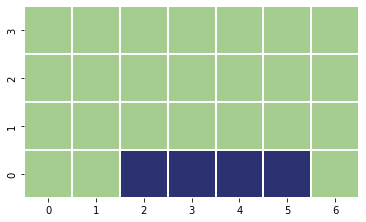

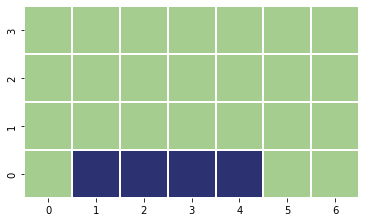

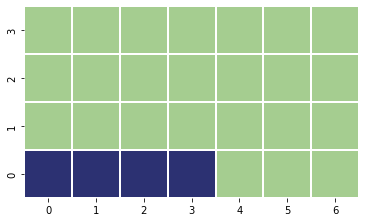

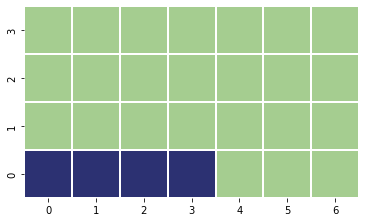

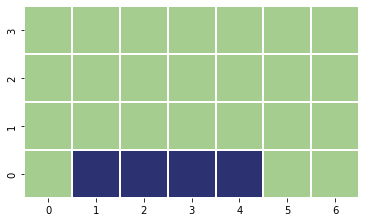

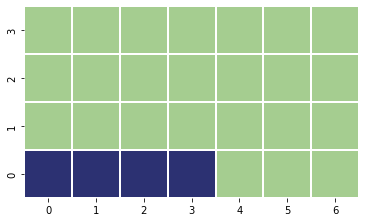

[[1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


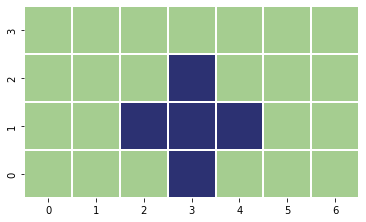

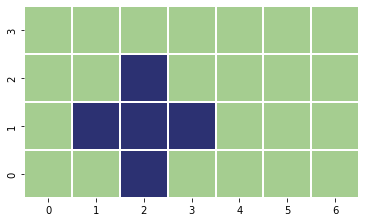

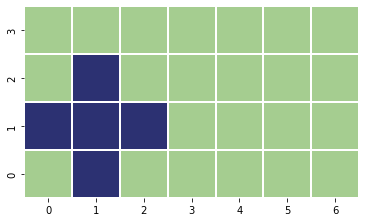

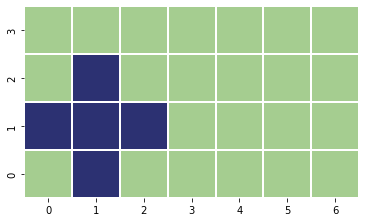

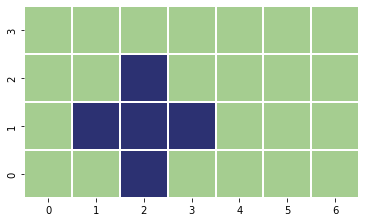

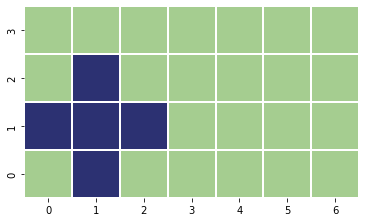

[[0 1 0 0 0 0 0]
 [1 1 1 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


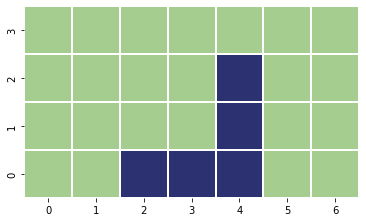

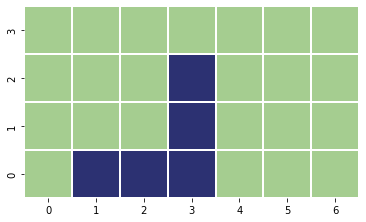

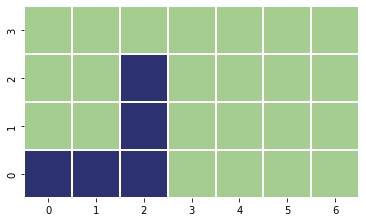

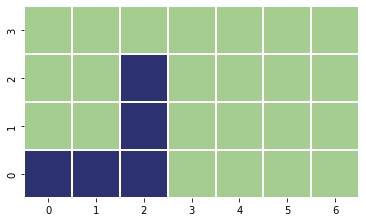

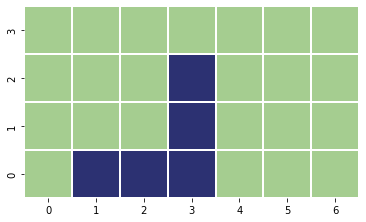

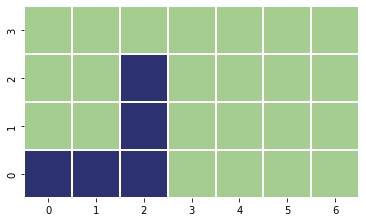

[[1 1 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]]


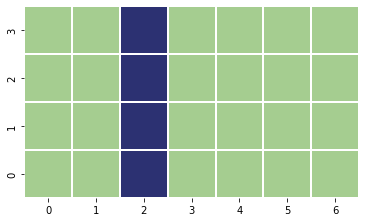

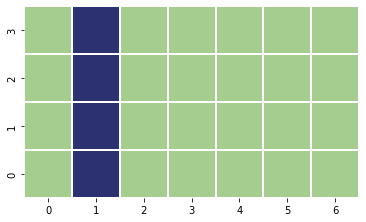

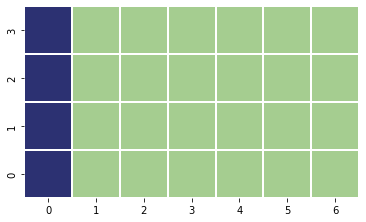

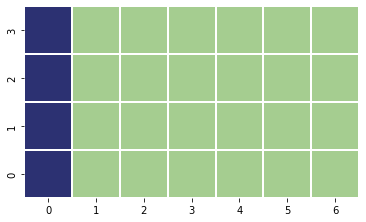

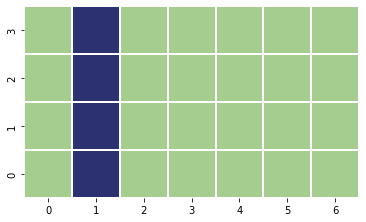

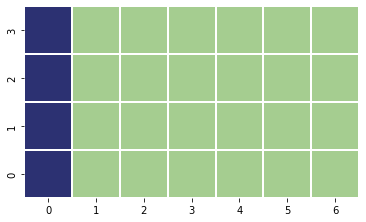

[[1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


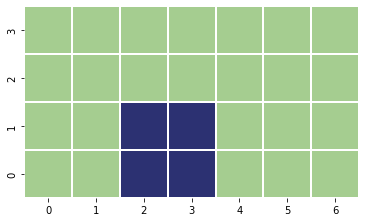

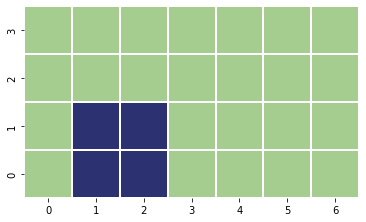

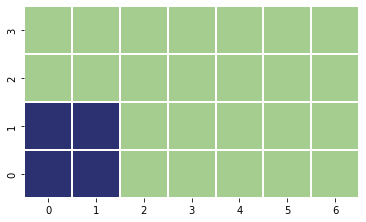

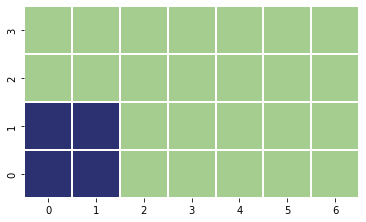

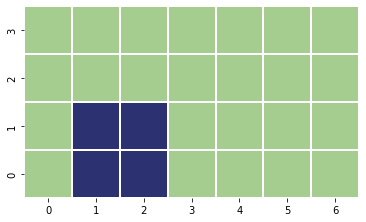

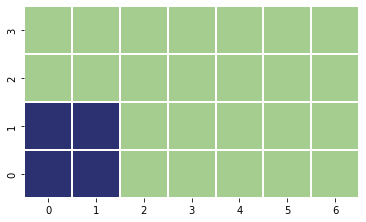

[[1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [35]:
je = Jets('<<<><')

for i in range(1,6):
    tt = Rock(i)
    tt.plot()
    for i in range(5):
        tt.apply_jet(je.get_next_jet())
        tt.plot()
    print(tt)

In [36]:
tt

[[1 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

In [37]:
np.where(tt.rock.sum(axis = 0)>0)[0][0]

0